# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [154]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [155]:
data_2019.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


EXPLORACION DE DATOS

Para llevar a cabo nuestro proyecto vamos a utilizar información sobre el Flujo Vehicular por Unidades de Peaje AUSA, extraída de la página oficial del Buenos Aires Data

Tomando solo los datos de los años 2017, 2018 y 2019. Ya que necesitamos predecir el Flujo Vehicular del último trimestre del año 2019.

En nuestros data set contamos con la siguiente información (columnas):

* **periodo**: año del data set 
* **fecha**: año-dia-mes
* **hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)
* **hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)
* **dia**: dia de la semana (Lunes,Martes,etc)
* **estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)
* **sentido**: Centro o Provincia
* **tipo_vehiculo**: Liviano o Pesado
* **forma_pago**: Hay varias y varian entre los años (Efectivo, Telepase, No Cobrado, etc).
* **cantidad_pasos**: Cantidad de vehiculos

Con estos datos vamos a predecir el Flujo Vehicular del último trimestre del año 2019 y también intentar responder algunas preguntas como:

Influye en el aumento/disminución del flujo vehicular el día de la semana ó mes de año?
En el transcurso de los tres años el flujo vehicular se mantiene, aumenta o disminuye ?

In [156]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [157]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [158]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [159]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [160]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [161]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [162]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [163]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [164]:
dataset.tail()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
1372316,2017-12-31,22,Domingo,Provincia,Pesado,8
1372319,2017-12-31,23,Domingo,Provincia,Liviano,8
1372320,2017-12-31,23,Domingo,Provincia,Liviano,148
1372324,2017-12-31,23,Domingo,Provincia,Pesado,1
1372326,2017-12-31,23,Domingo,Provincia,Pesado,1


In [165]:
dataset #238869 rows × 6 columns

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769
...,...,...,...,...,...,...
1372316,2017-12-31,22,Domingo,Provincia,Pesado,8
1372319,2017-12-31,23,Domingo,Provincia,Liviano,8
1372320,2017-12-31,23,Domingo,Provincia,Liviano,148
1372324,2017-12-31,23,Domingo,Provincia,Pesado,1


In [166]:
# Analisamos las estadisticas del dataset.
dataset.describe()

,hora_fin,cantidad_pasos
count,238869.000000,238869.000000
mean,11.874659,200.384232
std,6.739129,403.246904
min,0.000000,1.000000
25%,6.000000,2.000000
50%,12.000000,11.000000
75%,18.000000,104.000000
max,23.000000,2416.000000


In [167]:
# vemos si hay valores faltantes.
dataset.isnull().sum()

fecha             0
hora_fin          0
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
dtype: int64

Al no haber valores faltante no debemos realizar la imputacion de los mismos.

In [168]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora.
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [169]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [170]:
#Reordenamos el dataset por fecha y asignamos un nuevo indice.
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


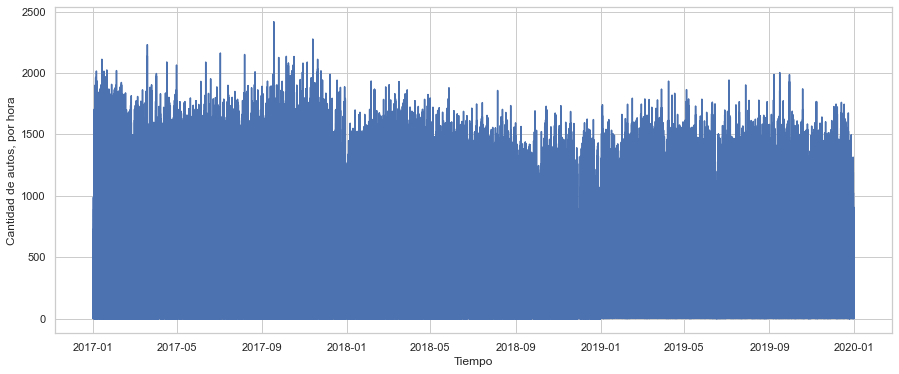

In [171]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [172]:
#Resampleamos nuestros datos para agrupar por dia,y ver si obtenemos una mejor visualización
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


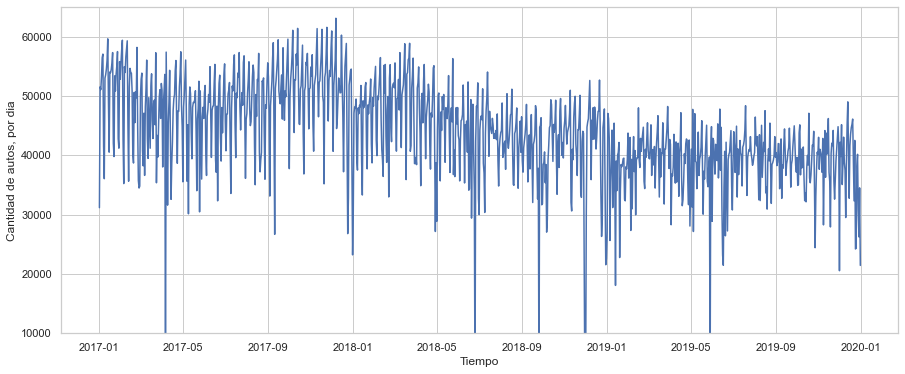

In [173]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylim(10000,65000)
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Del grafico anterior podemos obvservar que existen valores atipicos.

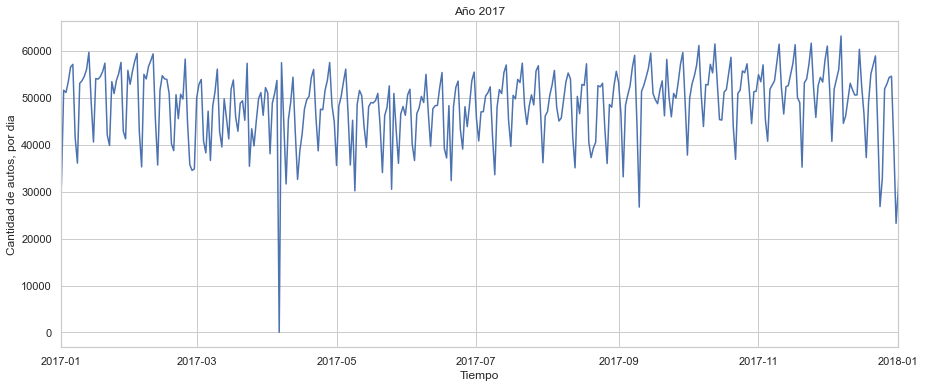

In [174]:
# Graficamos por año para poder visualizar mejor los valores atipicos
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.xlim(datetime.date(2017,1,1), datetime.date(2018,1,1))
plt.ylabel('Cantidad de autos, por dia')
plt.title('Año 2017')
plt.show()

Podemos observar que existe un valor atipico en el periodo 2017, la fecha es el 06/04/2017, que luego de haber googleado se encontro que hubo un paro general de la CGT

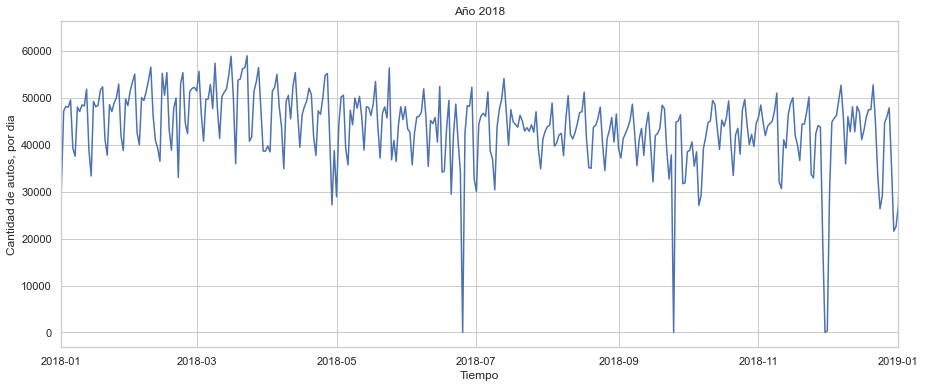

In [175]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
plt.ylabel('Cantidad de autos, por dia')
plt.title('Año 2018')
plt.show()

En 2018 podemos visualizar 3 valores atípicos en las siguientes fechas:

25/06/2018 : La CGT convocó la huelga después de que fracasaran distintas negociación con el Gobierno.

25/09/2018 : La CGT, con la adhesión de las tres CTA y movimientos sociales, realiza paro general contra el gobierno.

Del 29/11 al 01/12 : feriado establecido por el Gobierno, con motivo de la Cumbre de Líderes del G-20.

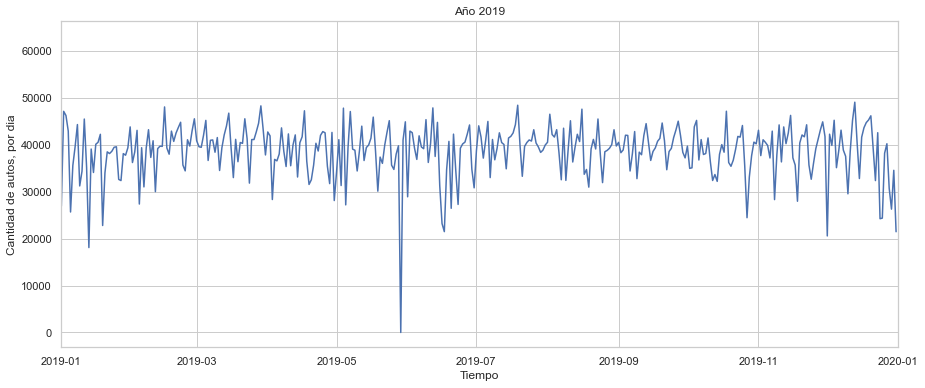

In [176]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.xlim(datetime.date(2019,1,1), datetime.date(2020,1,1))
plt.ylabel('Cantidad de autos, por dia')
plt.title('Año 2019')
plt.show()

En 2019 podemos visualizar 1 valor atípico el 29 de mayo:

El miércoles 29 de mayo la CGT anunció el quinto paro general de 24 horas en rechazo a las políticas económicas del gobierno de Mauricio Macri.

Con el analisis realizado de los valores atípicos decidimos eliminar esos valores, ya que no aportan valor a nuestro data set.
Porque son fechas de paros/huelgas donde la gente no circuló pero que no tienen estacionalidad en los años porque son fechas aisladas:
*  2017-04-06, 2018-06-25, 2018-09-25, 2018-11-30, 2018-12-01, 2019-05-29

In [177]:
diario[diario.cantidad_pasos < 10000]

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


In [178]:
#Filtramos los 6 valores atípicos mostrados anteriormente
diario = diario[diario.cantidad_pasos > 10000]
diario

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486
...,...
2019-12-27,40182
2019-12-28,30681
2019-12-29,26259


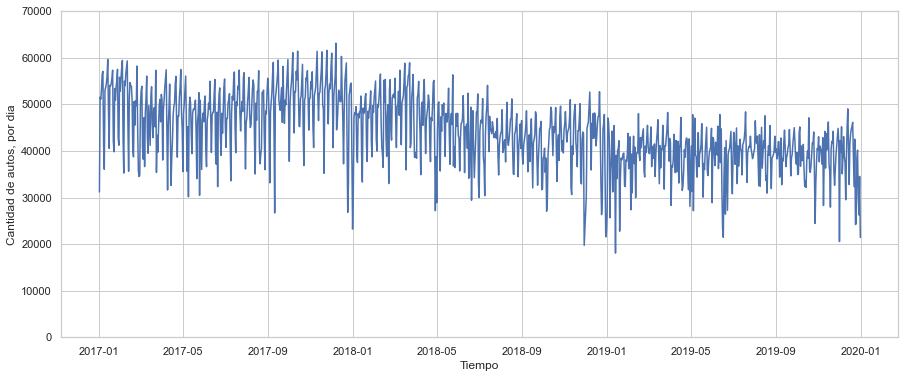

In [179]:
#Graficamos sin los valores atípicos
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylim(0,70000)
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [180]:
# creamos una nueva columna que nos indique con numero el dia de la semana donde 0 es lunes y 6 domingo.
diario['dia'] = diario.index
diario['dia_de_la_semana']= diario.dia.dt.dayofweek
diario


,cantidad_pasos,dia,dia_de_la_semana
fecha,,,
2017-01-01,31183,2017-01-01,6
2017-01-02,51568,2017-01-02,0
2017-01-03,51093,2017-01-03,1
2017-01-04,53332,2017-01-04,2
2017-01-05,56486,2017-01-05,3
...,...,...,...
2019-12-27,40182,2019-12-27,4
2019-12-28,30681,2019-12-28,5
2019-12-29,26259,2019-12-29,6


In [181]:
diario['semana_del_anio']= diario.dia.dt.isocalendar().week
diario
# por trimestre
# y = cantidad de pasos
# x = cantidad de semanas del año
# agrupacion = dia de la semana

,cantidad_pasos,dia,dia_de_la_semana,semana_del_anio
fecha,,,,
2017-01-01,31183,2017-01-01,6,52
2017-01-02,51568,2017-01-02,0,1
2017-01-03,51093,2017-01-03,1,1
2017-01-04,53332,2017-01-04,2,1
2017-01-05,56486,2017-01-05,3,1
...,...,...,...,...
2019-12-27,40182,2019-12-27,4,52
2019-12-28,30681,2019-12-28,5,52
2019-12-29,26259,2019-12-29,6,52


In [182]:
diario.reset_index(drop = True, inplace = True)

In [183]:
diario

,cantidad_pasos,dia,dia_de_la_semana,semana_del_anio
0,31183,2017-01-01,6,52
1,51568,2017-01-02,0,1
2,51093,2017-01-03,1,1
3,53332,2017-01-04,2,1
4,56486,2017-01-05,3,1
...,...,...,...,...
1084,40182,2019-12-27,4,52
1085,30681,2019-12-28,5,52
1086,26259,2019-12-29,6,52
1087,34523,2019-12-30,0,1


In [184]:
diario['semana_del_anio'].shape

(1089,)

In [185]:
diario['cantidad_pasos'].shape

(1089,)

In [186]:
# convertimos en variable float los valores de la columnas semana del año y cantidad de pasos.
diario['semana_del_anio'] = np.array(diario['semana_del_anio'], dtype=float)
diario['cantidad_pasos'] = np.array(diario['cantidad_pasos'], dtype=float)

(20000.0, 65000.0)

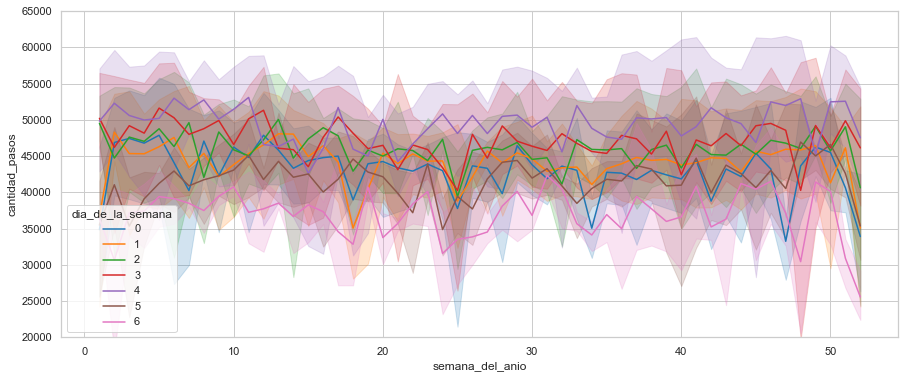

In [187]:
#Graficamos la cantidad de pasos según la semana del año, agrupado por día de la semana
sns.set(style="whitegrid")
color = sns.color_palette("tab10", 7)

plt.figure(figsize = (15,6))
sns.lineplot(x="semana_del_anio", y="cantidad_pasos",
             hue="dia_de_la_semana",
             data=diario, palette = color)
plt.ylim(20000,65000)
#0 -> Lunes / 6 -> Domingo

De este grafico podemos sacar las siguientes conclusiones:

 * Los dias Domingos son los dias de la semana que menos cantidad de pasos tienen durante todo el año.
 
 * Los dias Jueves y Viernes son los dias de la semana que mayor cantidad de pasos tienen durante el año.
 
 * Los Dias Sabados tiene una mayor cantidad de pasos que los domingo pero menor que el resto de los dias.
 
 * Los dias Lunes, Martes y Miercoles estan con un nivel de pasos intermedios entre los dias mencionados anteriormente.
 

In [188]:
#Creamos una nueva columna que solo tenga el año
diario['anio'] = diario.dia.dt.year

In [189]:
#Creamos una nueva columna que solo tenga el mes
diario['mes'] = diario.dia.dt.month
diario

,cantidad_pasos,dia,dia_de_la_semana,semana_del_anio,anio,mes
0,31183.0,2017-01-01,6,52.0,2017,1
1,51568.0,2017-01-02,0,1.0,2017,1
2,51093.0,2017-01-03,1,1.0,2017,1
3,53332.0,2017-01-04,2,1.0,2017,1
4,56486.0,2017-01-05,3,1.0,2017,1
...,...,...,...,...,...,...
1084,40182.0,2019-12-27,4,52.0,2019,12
1085,30681.0,2019-12-28,5,52.0,2019,12
1086,26259.0,2019-12-29,6,52.0,2019,12
1087,34523.0,2019-12-30,0,1.0,2019,12


(30000.0, 60000.0)

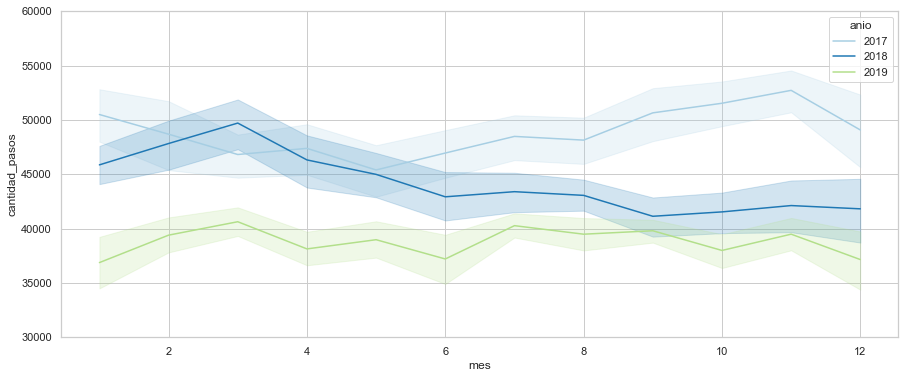

In [190]:
#Graficamos según el año la cantidad de pasos, agrupados por mes.
sns.set(style="whitegrid")
color = sns.color_palette("Paired", 3)
plt.figure(figsize = (15,6))
sns.lineplot(x="mes", y="cantidad_pasos",
             hue="anio",
             data=diario, palette = color)
plt.ylim(30000,60000)

Del grafico podemos concluir que en el año 2017 es un año en el que la cantidad de pasos aumenta en el transcurso de los meses, luego en el año 2018 comienza con una cantidad de pasos similar y hasta un poco mayor que en el 2017 pero a partir de abril del 2018 se observa una disminución en la cantidad de paso, pudiendo estar esto asociado a la crisis de abril del 2018 en la cual se produjo la devaluación del Peso.
Luego en el año 2019 se observa estabilidad en cuanto a la cantidad de los pasos, pero el año con menor cantidad de pasos por mes.


### 2. Modelo Machine Learning.

Para comenzar a desarrollar el modelo debemos reducir los datos, utilizando una función para pasar de series de tiempo a una tabla.

In [191]:
diario.head()

,cantidad_pasos,dia,dia_de_la_semana,semana_del_anio,anio,mes
0,31183.0,2017-01-01,6,52.0,2017,1
1,51568.0,2017-01-02,0,1.0,2017,1
2,51093.0,2017-01-03,1,1.0,2017,1
3,53332.0,2017-01-04,2,1.0,2017,1
4,56486.0,2017-01-05,3,1.0,2017,1


In [192]:
#REDUCCION: función pasamos de series de tiempo a una tabla 
#- esto lo necesitamos para crear nuestro Modelo de Machine Learning

def split_into_train_test(data, window_size, horizon):
    """
    Splits the series into train and test sets. Each step takes multiple points as inputs
    :param data: an individual TS
    :param window_size: number of input points for the forecast
    :param horizon: number of out of sample points
    :return:
    """
    train, test = data[:-horizon], data[-(horizon + window_size):]
    X_train, y_train = train[:-1], np.roll(train, -window_size)[:-window_size]
    X_test, y_test = test[:-1], np.roll(test, -window_size)[:-window_size]

    # Hago el reshape
    X_train = np.reshape(X_train, (-1, 1))
    X_test = np.reshape(X_test, (-1, 1))
    temp_test = np.roll(X_test, -1)
    temp_train = np.roll(X_train, -1)
    for x in range(1, window_size):
        X_train = np.concatenate((X_train[:-1], temp_train[:-1]), 1)
        X_test = np.concatenate((X_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return X_train, y_train, X_test, y_test

In [193]:
diario.cantidad_pasos.values

array([31183., 51568., 51093., ..., 26259., 34523., 21447.])

Hacemos un train-test-split de nuestros datos, definiendo:

    -ventana de tiempo: Numero de tiempo en pasado que voy a usar para predecir (look_back)
    -horizonte: periodo de tiempo predicho
    -datos: cantidad de pasos

In [194]:
# nuestro modelo utiliza para predecir la informacion del año anterior (365 dias antes)
ventana = 365    #un año(365 dias)
horizonte = 90   #trimestre
serie_tiempo = diario.cantidad_pasos.values
X_train, y_train, X_test, y_test = split_into_train_test(serie_tiempo, ventana, horizonte)

In [195]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(634, 365) (634,)
(90, 365) (90,)


In [196]:
#Creamos y entrenamos nuestro modelo

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

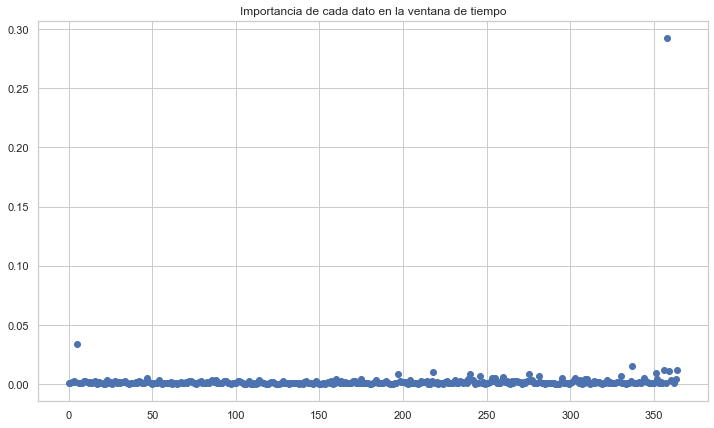

In [197]:
#Graficamos la importancia de cada dato de nuestra ventana

plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
plt.title('Importancia de cada dato en la ventana de tiempo')
plt.show()


Podemos analizar que los datos con mayor importancia son:
 - X364."Ayer". es el dato que tiene mayor importancia en nuestra ventana de tiempo.
 - x0. "un año atrás" tiene un poco más importancia que el resto de los datos.

Por lo que los datos más importantes son a fin de año y comienzo de año.

#### ONE STEP

In [198]:
#y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [199]:
#Calculamos el error 
rmse_train_one_step = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('Raíz del error cuadrático medio en Train:',f'{rmse_train_one_step:,.0f}'.replace(',','.'))


rmse_test_one_step = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('Raíz del error cuadrático medio en Test:',f'{rmse_test_one_step:,.0f}'.replace(',','.'))

Raíz del error cuadrático medio en Train: 1.878
Raíz del error cuadrático medio en Test: 6.052


In [200]:
senial = diario.cantidad_pasos
senial

0       31183.0
1       51568.0
2       51093.0
3       53332.0
4       56486.0
         ...   
1084    40182.0
1085    30681.0
1086    26259.0
1087    34523.0
1088    21447.0
Name: cantidad_pasos, Length: 1089, dtype: float64

In [201]:
look_back = ventana

N_train = len(y_train)
N_test = len(y_test)

N_total = N_train + N_test

length_total = N_train + N_test + look_back

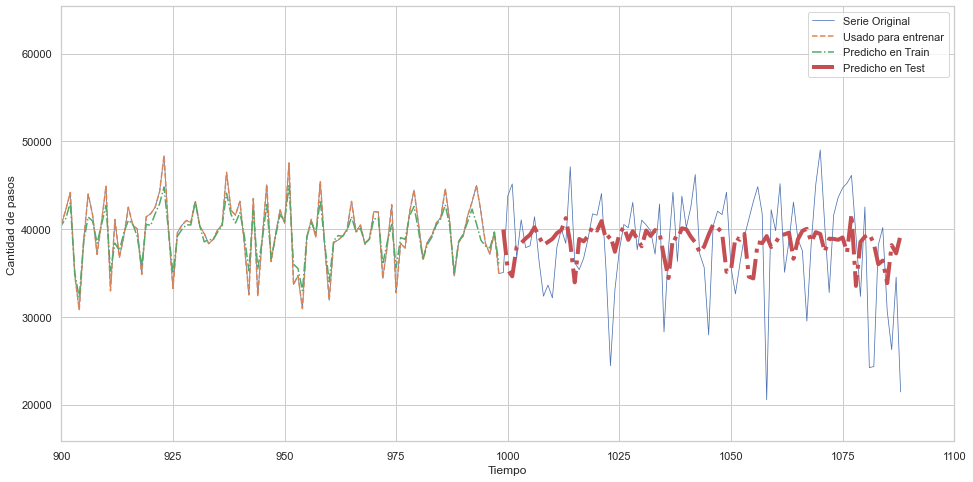

In [202]:
#Graficamos nuestra predicción
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(900,1100)
plt.show()

#### Optimizacion de hiperparametros con Grid Search

In [203]:
from sklearn.model_selection import GridSearchCV

In [204]:
#GRID SEARCH
param_grid = {'n_estimators':[10,50,100],
              'max_depth':[5,10,14],
              'max_features': ['sqrt2', 'log2',2,8],
              'min_samples_leaf':[3,5,10],
              'min_samples_split':[6,8,10],
               'max_leaf_nodes':[10,30,None]}

#model = RandomForestRegressor(random_state=42)
#gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error',n_jobs=5)
#gs.fit(X_train,y_train)

#print(gs.best_params_)
#print(-gs.best_score_)

In [205]:
rfr = RandomForestRegressor(max_depth=10,max_features='log2',min_samples_leaf=3,
                            min_samples_split=6,max_leaf_nodes=None,n_estimators=100,random_state=42,n_jobs=4).fit(X_train,y_train)

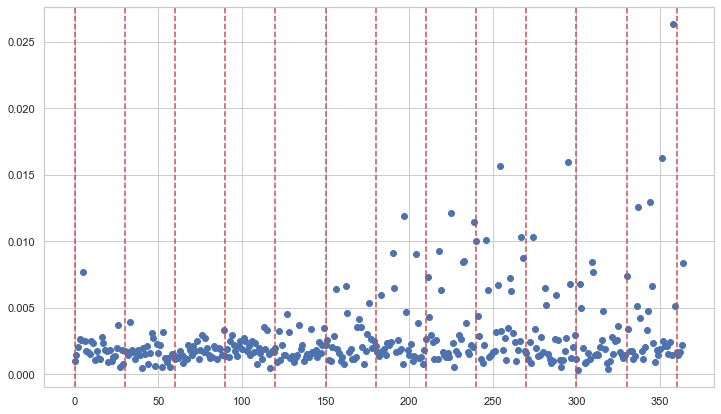

In [206]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rfr.feature_importances_.size),rfr.feature_importances_)
for x in np.arange(13)*30:
    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

Podemos analizar que los puntos del gráfico anterior mantienen la misma importancia,pero los demás puntos incrementan su importancia a medida que los días del año van incrementando.
Por lo que para predecir son más importantes los días dentro de un rango de 150 días a 365.
Siendo los que en los últimos 6 meses del año la importancia de los datos aumenta para la predicción futura.

In [225]:
#Predicción

#y_pred = rf.predict(X)
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

In [227]:
#Calculamos el error 
rmse_train_gs_one_step = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('Raíz del error cuadrático medio en Train:',f'{rmse_train_gs_one_step:,.0f}'.replace(',','.'))

rmse_test_gs_one_step = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('Raíz del error cuadrático medio en Test:',f'{rmse_test_gs_one_step:,.0f}'.replace(',','.'))

Raíz del error cuadrático medio en Train: 2.861
Raíz del error cuadrático medio en Test: 5.819


In [209]:
senial = diario.cantidad_pasos
senial

0       31183.0
1       51568.0
2       51093.0
3       53332.0
4       56486.0
         ...   
1084    40182.0
1085    30681.0
1086    26259.0
1087    34523.0
1088    21447.0
Name: cantidad_pasos, Length: 1089, dtype: float64

In [210]:
look_back = ventana

N_train = len(y_train)
N_test = len(y_test)

N_total = N_train + N_test

length_total = N_train + N_test + look_back

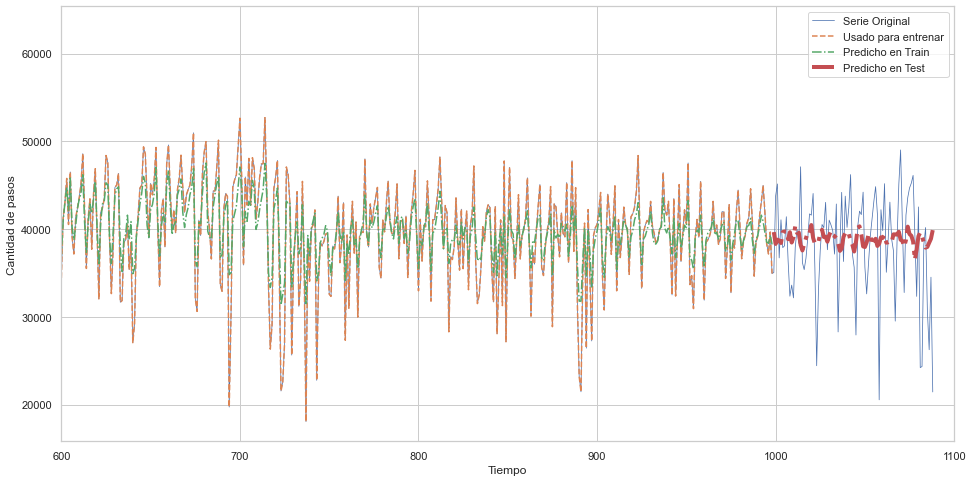

In [211]:
#Graficamos nuestra predicción
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.xlim(600,1100)
plt.show()

#### MULTI STEP

In [212]:
#Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

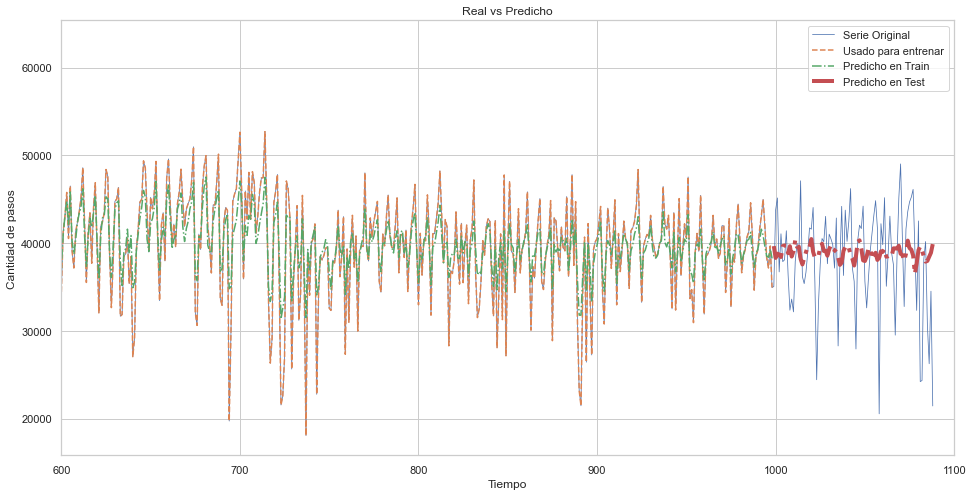

In [213]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.title('Real vs Predicho')
plt.xlim(600,1100)
plt.show()

In [214]:
rmse_train_multi_step = np.sqrt(mean_squared_error(y_test, y_ms_test_pred))
print('Error en Train:',np.sqrt(MSE))

Error en Train: 6674.689455947246


#### BENCHMARK

Con el modelo benchmark comparamos el error con el que habríamos obtenido si predecíamos copiando el valor de la fecha anterior.

In [215]:
X_train.size

231410

In [216]:
y_train.size

634

In [217]:
last = y_train[-1]

In [218]:
type(y_test)

numpy.ndarray

In [219]:
y_test.shape

(90,)

In [220]:
y_test_pred_benchmark = np.ones(shape = y_test.shape) * last
y_test_pred_benchmark

array([34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943., 34943., 34943., 34943., 34943., 34943., 34943.,
       34943., 34943.])

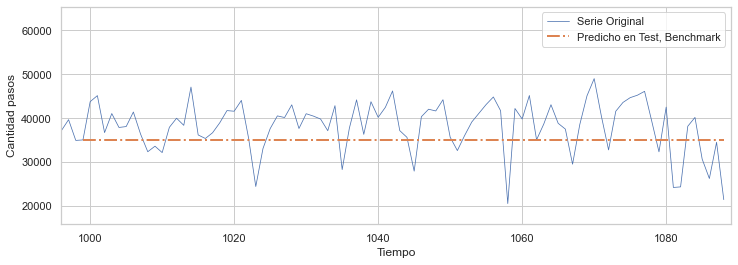

In [221]:
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
#plt.xlim(senial.index[N_train+look_back], senial.index[length_total-1])
plt.xlim(996,1089)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad pasos')
plt.legend()
plt.show()

In [222]:
rmse_train_benchmark = np.sqrt(mean_squared_error(y_test, y_test_pred_benchmark))
print('Error en Train:',np.sqrt(MSE))

Error en Train: 6674.689455947246


# Conclusiones.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


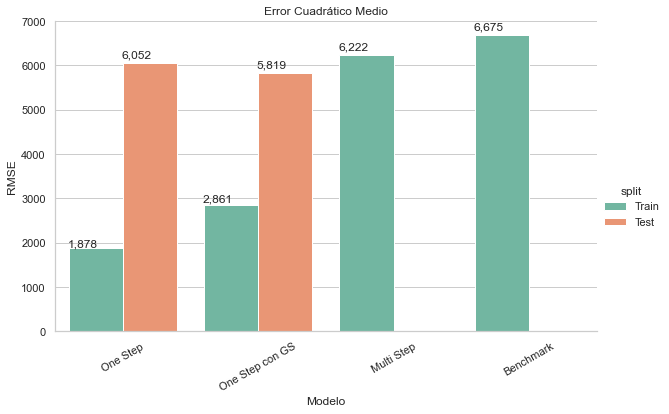

In [223]:
name_f=['rmse_train', 'rmse_test', 'rmse_train', 'rmse_test', 'rmse_train', 'rmse_train' ]
value_f = [rmse_train_one_step, rmse_test_one_step,
         rmse_train_gs_one_step, rmse_test_gs_one_step,
         rmse_train_multi_step,
         rmse_train_benchmark ]
split_f=['Train', 'Test', 'Train', 'Test', 'Train', 'Train']
model_f=['One Step','One Step',
       'One Step con GS', 'One Step con GS',
       'Multi Step',
       'Benchmark']

dicc_f= {'rmse':name_f,'value':value_f,'split':split_f, 'model':model_f }
df_f = pd.DataFrame(dicc_f)

figsize=(30,10)

# Draw a nested barplot by species and sex
g = sns.catplot(data=df_f, kind="bar", x="model", y="value", hue="split",
                ci="sd", palette="Set2", aspect=10/6)
g.set_xticklabels(rotation=30)

plt.title('Error Cuadrático Medio')
plt.xlabel('Modelo')
plt.ylabel('RMSE')


ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.01, p.get_height() * 1.02, '{0:,.0f}'.format(p.get_height()))

El modelo que tiene mayor Error en Train es nuestro modelo de Benchmark que copia el valor de la fecha anterior para predecir.

Comparando los modelos de One Step con Multi Step, podemos analizar que el modelo Multi Step es peor en Train, pero es mejor que el modelo benchmark.

Y comparando nuestros modelos de One Step, el modelo con optimización de hiperparametros es más robusto ya que la diferencia entre Train y Test es menor, que la diferencia del primer modelo de One Step sin optimización de hiperparametros.

##### INVESTIGACION

- Planteando nuevos interrogatorios en base al trabajo realizado:

  * ¿Influye en la predicción el tipo de vehículo y la hora de los días?
  
    ¿En este sentido podríamos analizar si hay alguna inferencia respecto del tipo de vehículo con las horas del día, ya que en días laborables en las horas pico el tránsito vehicular es liviano?  bajo la premisa de que en esos horarios la gente se desplaza hacia sus oficinas en auto. 
    ¿Que tipo de vehículos transitan según la hora del día?
          
  
  * ¿Influye en la predicción el sentido de circulación y la hora de los días?
  
    ¿Cuál es el sentido de circulación según las horas del día? Podríamos imaginar que en las primeras horas de la mañana la       gente se desplaza de provincia al centro ya que se desplazan a Oficinas, colegios, etc.
    y en sentido contrario la gente lo hace en horarios de la tarde.
    
- Planteando flujos de trabajo que respondan estas preguntas:

  * respecto del tipo de vehículo y las horas del día, podríamos filtrar nuestro dataset según las horas del día y el tipo de vehículo, y graficar por horas del día según el tipo de vehículos. De este modo podríamos analizar si el transito liviano se da más en los horarios pico de circulación y el pesado en horarios diferentes.
 
  * respecto del sentido de circulación según las horas del día, también filtraríamos el dataset por horas y sentido de circulación, realizando luego un gráfico por horas del día y sentido de circulación, y analizar si las primeras y últimas horas de los días laborales hay mayor cantidad de paso, y analizar si en las primeras horas del día la circulación es en sentido centro y en las últimas es sentido provincia.
De esta manera, con este nuevo dataset filtrado, volveríamos a entrenar nuestros modelos (One Step, One Step con optimización de hiperparámetros, Multi Step y nuestro Benchmark).
Luego de entrenar nuestros modelos, compararíamos nuestras predicciones y analizaríamos si en las predicciones mejoran o empeoran con el nuevo planteo de los datos. Podríamos así concluir si el sentido de circulación, el horario de circulación y el tipo de vehículo tiene mayor o menor influencia en nuestras predicciones.



##### Link al repositorio de GitHub